In [1]:
import numpy as np
import requests
import matplotlib.pyplot as plt

# Download the dataset from the Exoplanet Archive:
url = "https://exoplanetarchive.ipac.caltech.edu/data/ExoData/0108/0108859/data/UID_0108859_RVC_001.tbl"
r = requests.get(url)
if r.status_code != requests.codes.ok:
    r.raise_for_status()
data = np.array(
    [
        l.split()
        for l in r.text.splitlines()
        if not l.startswith("\\") and not l.startswith("|")
    ],
    dtype=float,
)
t, rv, rv_err = data.T
t -= np.mean(t)

lit_period = 3.52474859


In [2]:
import RV_exoplanets_module as rvexo

trace, map_params, phase, rvphase = rvexo.exoplanet_MCMC(t, rv, rv_err, lit_period)

optimizing logp for variables: [rvtrend, rv0, hk, phi, logP, logK]


message: Desired error not necessarily achieved due to precision loss.
logp: -11535.01822648265 -> -208.63484499015496
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rvtrend, rv0, hk, phi, logP, logK]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.


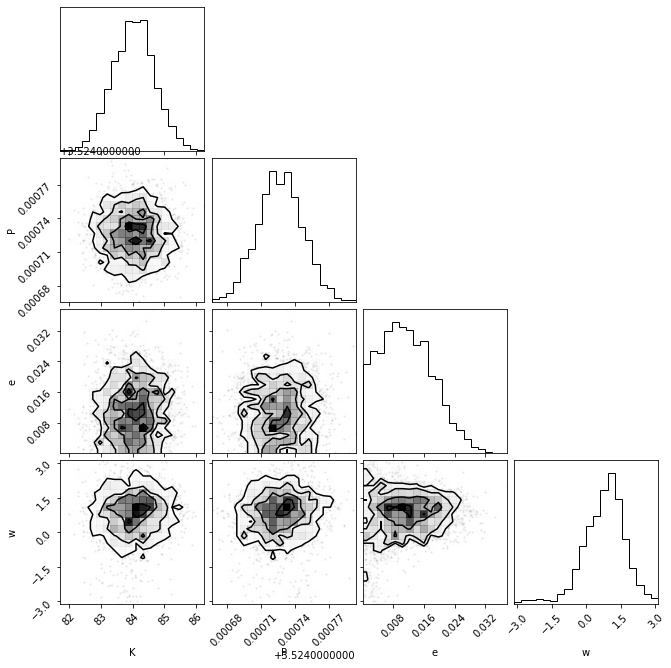

In [3]:
# corner plot
import corner

_ = corner.corner(trace, var_names=["K", "P", "e", "w"])


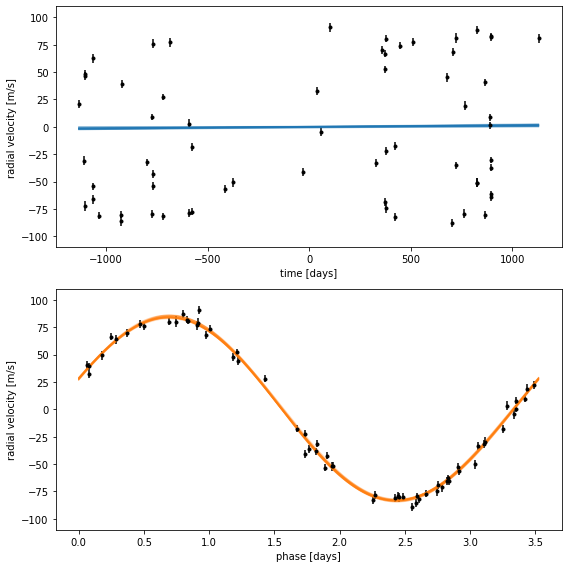

In [4]:
# plot results

fig, axes = plt.subplots(2, 1, figsize=(8, 8))

period = map_params["P"]

ax = axes[0]
ax.errorbar(t, rv, yerr=rv_err, fmt=".k")
ax.set_ylabel("radial velocity [m/s]")
ax.set_xlabel("time [days]")

ax = axes[1]
ax.errorbar(t % period, rv - map_params["bkg"], yerr=rv_err, fmt=".k")
ax.set_ylabel("radial velocity [m/s]")
ax.set_xlabel("phase [days]")

bkg = trace.posterior["bkg"].values
rvphase = trace.posterior["rvphase"].values

for ind in np.random.randint(np.prod(bkg.shape[:2]), size=25):
    i = np.unravel_index(ind, bkg.shape[:2])
    axes[0].plot(t, bkg[i], color="C0", lw=1, alpha=0.3)
    axes[1].plot(phase * period, rvphase[i], color="C1", lw=1, alpha=0.3)

axes[0].set_ylim(-110, 110)
axes[1].set_ylim(-110, 110)

plt.tight_layout()

